分类正确率:0.76


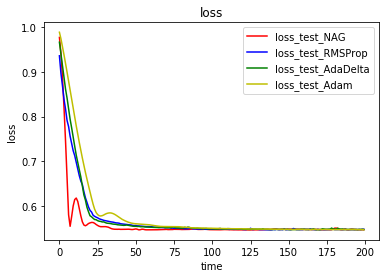

In [4]:
#实验名称：线性分类与随机梯度下降
#实验目的：理解线性分类，理解梯度下降与随机梯度下降的区别和联系
#实验日期：2017/12/9

import os 
os.chdir('E://dataset')
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

#使用load_svmlight_file读取数据,分别读取训练集和测试集
X_train, y_train = load_svmlight_file('a9a.txt', n_features = 123)
X_train = X_train.toarray()
X_train = np.c_[X_train, np.ones((X_train.shape[0],1))]
y_train = y_train.reshape(y_train.shape[0], 1)

X_test, y_test = load_svmlight_file('a9at.txt', n_features = 123)
X_test = X_test.toarray()
X_test = np.c_[X_test, np.ones((X_test.shape[0],1))]
y_test = y_test.reshape(y_test.shape[0], 1)

#初始化参数
LAMBDA = 1
C=1
sampleBatchNum = 100      #随机取样的batch为100

#此函数为从训练集中随机选取数量为batch的训练样本
def samples_selection(X, y, samplesNum):
    index = range(0, X.shape[0])
    samples_index = random.sample(index, samplesNum)
    X_selection = np.ones((0, X.shape[1]))
    y_selection = np.ones((0, y.shape[1]))
    for i in samples_index:
        X_selection = np.r_[X_selection, X[i].reshape(1, X.shape[1])]
        y_selection = np.r_[y_selection, y[i].reshape(1,y.shape[1])]
    return X_selection, y_selection

#计算hingeLoss
def calHingeLoss(Yi,Xi,W):
    middle = Yi * np.dot(W.T, Xi.T)
    result = 1 - middle[0][0]
    if result > 0:
        hingeLoss = result
    else:
        hingeLoss = 0
    return hingeLoss

#计算梯度函数
def calGradient(X_t, y_t, W):
    temp = np.zeros(W.shape)
    for index in range(X_t.shape[0]):
        Yi = y_t[index][0]
        Xi = X_t[index].reshape(1,X_t.shape[1])
        hingeLoss = calHingeLoss(Yi, Xi, W)
        if hingeLoss > 0:   
            temp = temp - Yi * Xi.T
        else:
            temp = temp + np.zeros((X_t.shape[1], 1))
    gradient = W + C / X_t.shape[0] * temp
    return gradient

#计算损失值函数
def calLoss(W, X_t, y_t):
    temp=0
    for index in range(y_t.shape[0]):
        Yi = y_t[index][0]
        Xi = X_t[index].reshape(1,X_t.shape[1])
        temp += calHingeLoss(Yi, Xi, W)
    temp = C * temp 
    loss = 1/2 * np.dot(W.T,W)[0][0] + temp/float(y_t.shape[0])
    return loss

#此函数计算预测的正确率
def calRightRate(W, X_t, y_t):
    right = 0
    for index in range(X_t.shape[0]):
        Ypredict= np.dot(X_t[index], W)
        if Ypredict > 0:
            Ypredict = 1
        else:
            Ypredict = -1
        if Ypredict == y_t[index][0]:
            right += 1
    rightRate = right / float(y_t.shape[0])
    return rightRate

#此函数计算使用NAG作为优化方法进行参数的的更新
def calNAG(W, Vt, eta, X_t, y_t):
    gamma = 0.9
    X_samples, y_samples = samples_selection(X_t, y_t, sampleBatchNum)
    W_ = W - gamma * Vt
    gt = calGradient(X_samples, y_samples, W_)
    Vt = gamma * Vt + eta * gt
    W = W - Vt
    return W, Vt  

#此函数计算使用NAG作为优化方法的loss值，并将loss记录在列表
def calLossOfNAG():
    W = np.zeros((X_train.shape[1],1))                   #参数初始化
    Vt = np.zeros(W.shape)
    gt = np.zeros(W.shape)  
    eta = 0.01
    iterTime = 200
    loss_test_list = []
    for i in range(iterTime):
        W, Vt = calNAG(W, Vt, eta, X_train, y_train)
    
        lossTest = calLoss(W, X_test, y_test)
        loss_test_list.append(lossTest)
    rightRateOfNAG = calRightRate(W, X_test, y_test)  
    rightRateOfNAG = round(rightRateOfNAG,2)
    print ('分类正确率:'+ str(rightRateOfNAG))
    return loss_test_list

#此函数计算使用RMSProp作为优化方法进行参数的的更新
def calRMSProp(W, Gt, eta, X_t, y_t):
    gamma = 0.95
    xigema = 1e-8
    X_samples, y_samples = samples_selection(X_t, y_t, sampleBatchNum)
    gt = calGradient(X_samples, y_samples, W)
    Gt = gamma * Gt + (1 - gamma) *(gt * gt)
    W = W - (eta / (np.sqrt(Gt + xigema))) * gt
    return W, Gt    

#此函数计算使用RMSProp作为优化方法的loss值，并将loss记录在列表
def calLossOfRMSProp():
    W = np.zeros((X_train.shape[1],1))               #参数初始化
    Gt = np.zeros(W.shape)
    eta = 0.002
    iterTime = 200
    loss_test_list = []
    for i in range(iterTime):
        W, Gt = calRMSProp(W, Gt, eta, X_train, y_train)  
        
        lossTest = calLoss(W, X_test, y_test)
        loss_test_list.append(lossTest)
    return loss_test_list

#此函数计算使用AdaDelta作为优化方法进行参数的的更新
def calAdaDelta(W, Gt, Delta_t, X_t, y_t):
    gamma = 0.9995
    xigema = 1e-8
    X_samples, y_samples = samples_selection(X_t, y_t, sampleBatchNum)
    gt = calGradient(X_samples, y_samples, W)
    Gt = gamma * Gt + (1-gamma) * (gt * gt)
    Delta_W = -1 * (np.sqrt(Delta_t + xigema) / np.sqrt(Gt + xigema)) * gt
    W = W + Delta_W
    Delta_t = gamma * Delta_t + (1 - gamma) * (Delta_W * Delta_W)    
    return W, Gt, Delta_t

#此函数计算使用AdaDelta作为优化方法的loss值，并将loss记录在列表
def calLossOfAdaDelta():
    W = np.zeros((X_train.shape[1],1))                     #参数初始化
    Gt = np.zeros(W.shape)
    Delta_t = np.zeros(W.shape)
    iterTime = 200
    loss_test_list = []
    for i in range(iterTime):
        W, Gt, Delta_t = calAdaDelta(W, Gt, Delta_t, X_train, y_train)  
        
        lossTest = calLoss(W, X_test, y_test)
        loss_test_list.append(lossTest)
    return loss_test_list

#此函数计算使用Adam作为优化方法进行参数的的更新
def calAdam(W, mt, Gt, eta, X_t, y_t):
    gamma = 0.999
    beta1 = 0.9
    xigema = 1e-8
    X_samples, y_samples = samples_selection(X_t, y_t, sampleBatchNum)
    gt = calGradient(X_samples, y_samples, W)
    mt = beta1 * mt + (1 - beta1) * gt
    Gt = gamma * Gt + (1- gamma) * (gt * gt)
    alpha = eta * (np.sqrt(1 - gamma) / np.sqrt(1-beta1))
    W = W - alpha * mt /np.sqrt(Gt + xigema)
    return W, mt, Gt

#此函数计算使用Adam作为优化方法的loss值，并将loss记录在列表
def calLossOfAdam():
    W = np.zeros((X_train.shape[1],1))               #参数初始化
    mt =np.zeros(W.shape)
    Gt = np.zeros(W.shape)
    eta = 0.005
    iterTime =200
    loss_test_list = []
    for i in range(iterTime):
        W, Gt, mt = calAdam(W, Gt, mt, eta, X_train, y_train)  
        
        lossTest = calLoss(W, X_test, y_test)
        loss_test_list.append(lossTest)
    return loss_test_list

#分别调用四种不同优化方法计算loss的函数，并将loss记录在列表
loss_test_NAG = calLossOfNAG()
loss_test_RMSProp = calLossOfRMSProp()
loss_test_AdaDelta = calLossOfAdaDelta()
loss_test_Adam = calLossOfAdam()

#使用matplotlib画出loss曲线图
plt.xlabel('time')
plt.ylabel('loss')
plt.title('loss')
x=range(len(loss_test_NAG))
plt.plot(x, loss_test_NAG, 'r-', label="loss_test_NAG")
plt.plot(x, loss_test_RMSProp, 'b-', label="loss_test_RMSProp")
plt.plot(x, loss_test_AdaDelta, 'g-', label="loss_test_AdaDelta")
plt.plot(x, loss_test_Adam, 'y-', label="loss_test_Adam")
plt.legend(loc='upper right')
plt.show()
